In [19]:
using Revise
using Pkg; Pkg.activate(".")
using HypergraphModularity

using Plots
using TimerOutputs
using StatsBase
using SparseArrays
using Plots
using Parameters
using LinearAlgebra
using Clustering
using DataFrames

 Activating environment at `~/hypergraph_modularities_code/Project.toml`
┌ Info: Precompiling HypergraphModularity [0c934d27-dd44-49d7-950f-bd4be7819e54]
└ @ Base loading.jl:1260
┌ Warning: Package HypergraphModularity does not have DelimitedFiles in its dependencies:
│ - If you have HypergraphModularity checked out for development and have
│   added DelimitedFiles as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with HypergraphModularity
└ Loading DelimitedFiles into HypergraphModularity from project dependency, future warnings for HypergraphModularity are suppressed.
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **



In [20]:
function detectabilityData(n, c₂, c₃, p₂, p₃)
    """
    construct a hypergraph of two clusters in which: 
    - n is the number of nodes (should be even)
    - c₂ is the mean number of 2-edges attached to a node
    - c₃ is the mean number of 3-edges attached to a node
    - p₂ is the proportion of 2-edges within clusters
    - p₃ is the proportion of 3-edges within clusters
    
    p₂ = 0 and p₃ = 1 for example, means that all 2-edges are between 
    cluster and all 3-edges are within cluster. 
    """
    n_group = n ÷ 2
    
    # numbers of edges of sizes 2 and 3
    m₂ = c₂*n/2
    m₃ = c₃*n/3
    
    # initialize edge dict
    E = Dict(k => Dict() for k ∈ 1:3)
    
    # assign 2-edges
    for i ∈ 1:m₂
        # within-cluster 2-edges
        if rand() < p₂
            s, t = 0, 0
            while s == t
                s, t = rand(1:n_group), rand(1:n_group)
            end
            if rand() < 0.5
                s += n_group
                t += n_group
            end
        # between-cluster 2-edges
        else
            s = rand(1:n_group)
            t = rand(1:n_group) + n_group
        end
        s, t = sort([s, t])
        E[2][[s,t]] = get(E[2], [s,t], 0) + 1
    end
    
    # assign 3-edges
    
    for i ∈ 1:m₃
        # within-cluster 3-edges
        if rand() < p₃
            s, t, v = 0, 0, 0
            while length(unique([s, t, v])) < 3
                s, t, v = rand(1:n_group), rand(1:n_group), rand(1:n_group)
            end
            if rand() < 0.5
                s += n_group
                t += n_group
                v += n_group
            end
        # between-cluster 2-edges
        else
            s, t, v = 0, 0, 0
            while length(unique([s, t, v])) < 3
                s = rand(1:n_group)
                t = rand(1:n_group)
                v = rand(1:n_group) + n_group
            end
            if rand() < 0.5
                s += n_group
                t += n_group
                v -= n_group
            end
            s, t, v = sort([s, t, v])
        end
        E[3][[s, t, v]] = get(E[3], [s, t, v], 0) + 1
    end
    H = hypergraph(N = 1:n, E = E)
    HypergraphModularity.computeDegrees!(H)
    return(H)
end

detectabilityData (generic function with 1 method)

In [4]:
function detectabilityExperiment(n, c₂, c₃, p₂, p₃; n_rounds = 10)
    
    kmax = 3
    weighted=false
    Ω = 0
    
    Z = vcat(repeat([1], n÷2), repeat([2], n÷2))
    H = detectabilityData(n, c₂, c₃, p₂, p₃)
        
    Z_ = copy(Z)
    
    γ̂ = computeDyadicResolutionParameter(H, Z_)
    ω_in, ω_out = computeDyadicResolutionParameter(H, Z_; mode="ω", weighted=weighted, pseudocount = 1.0)
    
    best_L = -Inf
    best_identified = 0
    best_dyadic_group_num = n
    
    for i in 1:n_rounds
        
        γ̂ = computeDyadicResolutionParameter(H, Z_)
        Z_ = CliqueExpansionModularity(H, γ̂, weighted, true, false)
        
        ω_in, ω_out = computeDyadicResolutionParameter(H, Z_; mode="ω", weighted=weighted, pseudocount = 0.0)
        L_D = dyadicLogLikelihood(H, Z_, ω_in, ω_out; weighted=weighted)
        
        k = length(unique(Z_))
        
        L_D -= n*log(k)
        
        if L_D > best_L
            best_L = L_D
            best_identified = randindex(Z, Z_)[1]
            best_dyadic_group_num = length(unique(Z_))
        end
    end
    
    best_dyadic_score = best_identified
    
    α0 = zeros(2*kmax)
    α̂ = α0
    
    Z_ = copy(Z)
    
    Ω = estimateΩEmpirically(H, Z_; aggregator = p -> [length(p) == 1, sum(p)], pseudocount = 1.0)
    
    best_L = -Inf
    best_identified = 0
    best_polyadic_group_num = n
    
    for i in 1:n_rounds
        Ω = estimateΩEmpirically(H, Z_; aggregator = p -> [length(p) == 1, sum(p)], pseudocount = 0.0)        
        Z_ = SuperNode_PPLouvain(H, Ω; α = α̂, verbose = false, Z0 = collect(1:n), clusterpenalty=n)
        L_H = modularity(H, Z_, Ω; α = α̂)
        
        k = length(unique(Z_))
        
        L_H -= n*log(k)
        
        if L_H > best_L
            best_L = L_H
            best_identified = randindex(Z, Z_)[1]
            best_polyadic_group_num = length(unique(Z_))
        end
    end
    
    best_hypergraph_score = best_identified
    
    return(best_dyadic_score, best_dyadic_group_num, best_hypergraph_score, best_polyadic_group_num)
end

detectabilityExperiment (generic function with 1 method)

In [14]:
H = detectabilityData(100, 5, 5,0.2, 0.4)

evalSums(repeat([1], 100), H)[3]

Dict{Array{Int64,1},BigInt} with 6 entries:
  [3]       => 946966168
  [1, 1]    => 0
  [1]       => 982
  [1, 1, 1] => 0
  [2]       => 964324
  [2, 1]    => 0

In [ ]:
# main experiment

c₂, c₃ = 5, 5

n_reps = 20

DFs = [DataFrame() for i in 1:n_reps]

Threads.@threads for rep ∈ 1:n_reps
    P₂, P₃, D, H, K_d, K_h = zeros(0), zeros(0), zeros(0), zeros(0), zeros(0), zeros(0)
    for p₂ ∈ 0:0.01:1, p₃ ∈ 0:0.01:1
        d, k_d, h, k_h = detectabilityExperiment(500, c₂, c₃, p₂, p₃)
        append!(P₂, p₂)
        append!(P₃, p₃)
        append!(D, d)
        append!(H, h)
        append!(K_d, k_d)
        append!(K_h, k_h)
    end
    DFs[rep] = DataFrame(
        P₂ = P₂, 
        P₃ = P₃, 
        D = D, 
        H = H, 
        K_d = K_d, 
        K_h = K_h
    )
end

# for p₂ ∈ 0:0.02:1, p₃ ∈ 0:0.02:1
#     for rep ∈ 1:10
#         d, k_d, h, k_h = detectabilityExperiment(500, c₂, c₃, p₂, p₃)
#         append!(P₂, p₂)
#         append!(P₃, p₃)
#         append!(D, d)
#         append!(H, h)
#         append!(K_d, k_d)
#         append!(K_h, k_h)
#     end
# end

In [ ]:
DF = DataFrame()
for df in DFs
    DF = vcat(DF, df)
end

In [ ]:
# # # troubleshooting

# c₂, c₃ = 5, 5
# P₂, P₃, D, H, K_d, K_h = zeros(0), zeros(0), zeros(0), zeros(0), zeros(0), zeros(0)

# for p₂ ∈ 0:0.1:1, p₃ ∈ 0:0.1:1, rep ∈ 1:1
#     d, k_d, h, k_h = detectabilityExperiment(500, c₂, c₃, p₂, p₃)
#     append!(P₂, p₂)
#     append!(P₃, p₃)
#     append!(D, d)
#     append!(H, h)
#     append!(K_d, k_d)
#     append!(K_h, k_h)
# end

In [1]:
using RCall
RCall.rcall_p(:options, rcalljl_options=Dict(:width => 450, :height => 200))
R"""
library(tidyverse)
library(viridis)
"""

┌ Warning: RCall.jl: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
│ ✔ ggplot2 3.3.2     ✔ purrr   0.3.4
│ ✔ tibble  3.0.3     ✔ dplyr   1.0.0
│ ✔ tidyr   1.1.0     ✔ stringr 1.4.0
│ ✔ readr   1.3.1     ✔ forcats 0.5.0
│ ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
│ ✖ dplyr::filter() masks stats::filter()
│ ✖ dplyr::lag()    masks stats::lag()
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160
┌ Warning: RCall.jl: Loading required package: viridisLite
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


RObject{StrSxp}
 [1] "viridis"     "viridisLite" "forcats"     "stringr"     "dplyr"      
 [6] "purrr"       "readr"       "tidyr"       "tibble"      "ggplot2"    
[11] "tidyverse"   "stats"       "graphics"    "grDevices"   "utils"      
[16] "datasets"    "methods"     "base"       


In [14]:
c₂, c₃ = 5, 5
R"""
df <- read_csv("fig/detectability_throughput.csv")
# df <- tibble($DF)

# df %>%     write_csv("fig/detectability_throughput.csv")
"""

┌ Warning: RCall.jl: Parsed with column specification:
│ cols(
│   `P₂` = col_double(),
│   `P₃` = col_double(),
│   D = col_double(),
│   H = col_double(),
│   K_d = col_double(),
│   K_h = col_double()
│ )
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


RObject{VecSxp}
# A tibble: 204,020 x 6
    `P₂`  `P₃`     D       H   K_d   K_h
   <dbl> <dbl> <dbl>   <dbl> <dbl> <dbl>
 1     0  0        0 0.00843   500    25
 2     0  0.01     0 0.00213   500    23
 3     0  0.02     0 0.00781   500    21
 4     0  0.03     0 0.00365   500    23
 5     0  0.04     0 0.0186    500    17
 6     0  0.05     0 0.0380    500    20
 7     0  0.06     0 0.00965   500    19
 8     0  0.07     0 0.0464    500    21
 9     0  0.08     0 0.107     500    16
10     0  0.09     0 0.0264    500    16
# … with 204,010 more rows


┌ Warning: RCall.jl: `summarise()` regrouping output by 'P_2', 'P_3' (override with `.groups` argument)
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


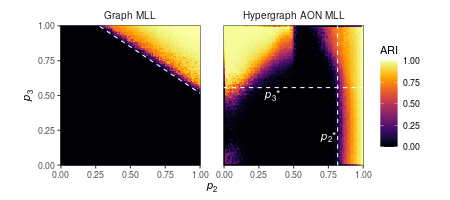

RObject{VecSxp}


┌ Warning: RCall.jl: Warning: Removed 13029 row(s) containing missing values (geom_path).
│ Warning: Removed 10201 rows containing missing values (geom_hline).
│ Warning: Removed 10201 rows containing missing values (geom_vline).
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


In [15]:

R"""
df <- df %>% 
    rename(P_2 = `P₂`, P_3 = `P₃`) %>%  
    mutate(D = ifelse((P_2 == 1)*(P_3 == 1) == 1, 1, D)) %>% 
    gather(key = method, value = ARI, -P_2, -P_3, -K_d, - K_h) %>% 
    group_by(P_2, P_3, method) %>% 
    summarise(ARI = mean(ARI)) %>% 
    mutate(method = ifelse(method == "D", "Graph", "Hypergraph")) %>%
    group_by(method, P_2, P_3) 

 df <- df %>% mutate(q_3 = (sqrt(2*($c₂ + 2*$c₃)) - (2*P_2-1)*$c₂)/(3*$c₃) + 1/3,
                    q_3 = ifelse(method == "Graph", q_3, NA),
                    q_3 = ifelse(q_3 > 1, NA, q_3),
                    r_3 = sqrt(4*$c₃)/(4*$c₃) + 1/3, 
                    r_3 = ifelse(method == "Hypergraph", r_3, NA),
                    r_2 = 1/sqrt(2*$c₂) + 1/2,
                    r_2 = ifelse(method == "Hypergraph", r_2, NA))

df <- df %>% 
    mutate(method = case_when(method == "Hypergraph" ~ "Hypergraph AON MLL", 
                              method == "Graph"     ~ "Graph MLL"))


labels <- data_frame(
    x = c(0.35, 0.75, 0.2),
    y = c(0.5, 0.2, 0.8),
    lab = c("paste(italic(p[3]), '*')", "paste(italic(p[2]), '*')", ""),
    method = c("Hypergraph AON MLL", "Hypergraph AON MLL", "Graph MLL")
)

df %>% 
    ggplot() + 
    facet_wrap(~method) + 
    geom_raster(aes(x = P_2, y = P_3, fill = ARI)) + 
    geom_line(aes(x = P_2, y = q_3), color = "white", linetype = "dashed") + 
    geom_hline(aes(yintercept = r_3), color = "white", linetype = "dashed") + 
    geom_vline(aes(xintercept = r_2), color = "white", linetype = "dashed") + 
    theme_bw() + 
    scale_fill_viridis(option = "inferno") + 
    scale_x_continuous(expand = c(0, 0)) + 
    scale_y_continuous(expand = c(0, 0)) + 
    theme(strip.background = element_blank(),
          panel.spacing.x = unit(8, "mm"),
          strip.text = element_text(size = 10)) +
    xlab(expression(italic(p)[2])) + 
    ylab(expression(italic(p)[3])) + 
    coord_fixed() + 
    geom_text(aes(x = x, y = y, label = lab), data = labels, color = "white", parse = T)
"""

In [16]:
R"""
ggsave("fig/detectability_2.png", width = 5.5, height = 2.7)
"""

┌ Warning: RCall.jl: Warning: Removed 13029 row(s) containing missing values (geom_path).
│ Warning: Removed 10201 rows containing missing values (geom_hline).
│ Warning: Removed 10201 rows containing missing values (geom_vline).
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


RObject{NilSxp}
NULL
